# Impact of L4 SHH Mapping Products on Lagrangian Drift Assessed on the EDITO Platform

In this Notebook we explore how the use of different Level 4 (L4) sea surface height (SSH) mapping products impacts the reconstruction of trajectory ensembles.

We experiment with 4 mapping products:
- DUACS ([DOI](https://doi.org/10.48670/moi-00145)), the global operational product distributed by Copernicus. It is resolved daily on a 1/4° grid and apply Optimal Interpolation (OI) ([Le Traon et al. 1998](1https://doi.org/0.1175/1520-0426(1998)015<0522:AIMMOM>2.0.CO;2)) to Nadir-like satellite observations.
- MIOST ([DOI](https://doi.org/10.24400/527896/a01-2022.011 )), a mapping method allowing to reconstruct global maps from both Nadir and SWOT SSH measurements ([Ubelmann et al. 2021](https://doi.org/10.1029/2020JC016560)). It is resolved daily on a 1/10° grid.
- VarDyn ([code](https://github.com/leguillf/MASSH)), a mapping technique using 4-Dimensional variational (4DVAR) scheme with a Quasi-Geostrophic (QG) model ([Le Guillou et al. 2021](https://doi.org/10.1175/JTECH-D-20-0104.1)). It is resolved every 6 hours on a 1/11° grid.
- 4dVarNet ([code](https://github.com/CIA-Oceanix/4dvarnet-core)), a a data-driven approach combining a data assimilation scheme associated with a deep learning framework ([Fablet 2022](https://imt-atlantique.hal.science/hal-04231225v1)). It is resolved daily on a 1/8° grid.

We focus here on only one reference trajectory, in the Gulf Stream region. It is the 2 weeks trajectory of the drifter identified with the WMO number 4402885, from 2023-08-23T00:00:00 to 2023-09-06T00:00:00 with a 6 hours temporal resolution.

We rely on OceanParcels ([Van Sebille et al. 2023](https://doi.org/10.5281/zenodo.8010997)) with a Smagorinsky horizontal diffusion (see OceanParcels documentation [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_diffusion.html#Example:-Using-horizontal-diffusion-calculated-from-velocity-fields)) to simulate our trajectory ensembles.

We assessed the impact of the SSH mapping products using two Lagrangian metrics:
- the separation distance (euclidean distance on a sphere),
- the Liu Index (a somehow normalised version of the separation distance, see [Liu and Weisberg 2011](https://doi.org/0.1029/2010JC006837) for details).

In order to derive indicators for the ensemble, we apply the Continuous Ranked Probability Score (CRPS) ([Thorey et al. 2017](https://doi.org/10.1002/qj.2940)) as our aggregation operator. This allows to balance ensemble fidelity to the only observation at our disposal with the ensemble dispersion.

## Dependencies

Uncomment the following two cells to install the required dependencies.

In [1]:
# !pip install cartopy clouddrift cmocean matplotlib numpy parcels s3fs xarray

In [2]:
# !pip install git+https://gitfront.io/r/vadmbertr/9qHVDfXFk3pZ/sealagrangiax.git

In [3]:
from datetime import datetime, timedelta
import math

import cartopy.crs as ccrs
import clouddrift as cd
import cmocean.cm as cmo
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import parcels
from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ScipyParticle,
    ParticleSet,
    Variable,
    download_example_dataset,
)
import s3fs
from sealagrangiax.trajectory import Trajectory, TrajectoryEnsemble
from sealagrangiax.utils.unit import time_in_seconds, seconds_to_days
import xarray as xr
import zarr

## Utility functions

We define here some utility functions used in the Notebook.

In [4]:
# read a zarr strore from a s3 bucket
def read_zarr(root: str, s3: s3fs.S3FileSystem) -> xr.Dataset:
    store = s3fs.S3Map(root=root, s3=s3)
    return xr.open_zarr(store)

In [5]:
# simulate an ensemble of trajectory using Smagorinsky diffusion
def simulate_traj_ensemble(
    mapping_product: str,
    drifter_wmo: int,
    start_time: np.datetime64,
    traj_length: np.timedelta64,
    ens_size: int,
    s3_root: str,
    s3_fs: s3fs.S3FileSystem
) -> (xr.Dataset, Trajectory, TrajectoryEnsemble):
    
    def smagdiff(particle, fieldset, time):
        dx = 0.01
        # gradients are computed by using a local central difference.
        updx, vpdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon + dx]
        umdx, vmdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon - dx]
        updy, vpdy = fieldset.UV[time, particle.depth, particle.lat + dx, particle.lon]
        umdy, vmdy = fieldset.UV[time, particle.depth, particle.lat - dx, particle.lon]
    
        dudx = (updx - umdx) / (2 * dx)
        dudy = (updy - umdy) / (2 * dx)
    
        dvdx = (vpdx - vmdx) / (2 * dx)
        dvdy = (vpdy - vmdy) / (2 * dx)
        
        A = fieldset.cell_areas[time, 0, particle.lat, particle.lon]
        sq_deg_to_sq_m = (1852 * 60) ** 2 * math.cos(particle.lat * math.pi / 180)
        A = A / sq_deg_to_sq_m
        Kh = fieldset.Cs * A * math.sqrt(dudx**2 + 0.5 * (dudy + dvdx) ** 2 + dvdy**2)
    
        dlat = parcels.ParcelsRandom.normalvariate(0.0, 1.0) * math.sqrt(
            2 * math.fabs(particle.dt) * Kh
        )
        dlon = parcels.ParcelsRandom.normalvariate(0.0, 1.0) * math.sqrt(
            2 * math.fabs(particle.dt) * Kh
        )
    
        particle_dlat += dlat
        particle_dlon += dlon

    # read sea surface currents dataset
    ssc_ds = read_zarr(root=f"{s3_root}/{mapping_product}.zarr", s3=s3_fs)
    if mapping_product != "duacs":
        ssc_ds["longitude"] = (ssc_ds["longitude"] + 180) % 360 - 180

    # create Parcels objects
    variables = {
        "U": "ugos",
        "V": "vgos",
    }
    dimensions = {"lat": "latitude", "lon": "longitude", "time": "time"}
    
    fieldset = FieldSet.from_xarray_dataset(ssc_ds, variables, dimensions)
    
    x = fieldset.U.grid.lon
    y = fieldset.U.grid.lat
    
    cell_areas = parcels.Field(
        name="cell_areas", data=fieldset.U.cell_areas(), lon=x, lat=y
    )
    fieldset.add_field(cell_areas)
    
    fieldset.add_constant("Cs", 0.1)

    # read drifters dataset
    drifters_ds = read_zarr(root=f"{s3_root}/gdp6h.zarr", s3=s3_fs)
    drifter_ds = cd.ragged.subset(
        drifters_ds,
        {
            "WMO": lambda wmo: (wmo == drifter_wmo).compute(),
            "time": lambda time: (time >= start_time) & (time < start_time + traj_length)
        },
        row_dim_name="traj"
    )
    
    pset = ParticleSet.from_list(
        fieldset=fieldset,
        pclass=JITParticle,
        lon = drifter_ds.lon[0].values * np.ones(ens_size),
        lat = drifter_ds.lat[0].values * np.ones(ens_size),
        time = start_time
    )
    
    output_file = pset.ParticleFile(
        name=f"traj_sim_{mapping_product}.zarr", 
        outputdt=timedelta(hours=6)
    )

    # simulate ensemble
    pset.execute(
        [AdvectionRK4, smagdiff],
        runtime=traj_length.item(),
        dt=timedelta(minutes=5),
        output_file=output_file,
    )

    traj_sim_ds = xr.open_zarr(f"traj_sim_{mapping_product}.zarr")

    # convert outputs
    times = time_in_seconds(drifter_ds.time.values)
    ref_traj = Trajectory(
        np.stack((drifter_ds.lat, drifter_ds.lon), axis=-1),
        times,
        drifter_wmo
    )
    ens_traj = TrajectoryEnsemble(
        np.stack((traj_sim_ds.lat, traj_sim_ds.lon), axis=-1),
        times
    )

    return ssc_ds, ref_traj, ens_traj

In [6]:
# plot a sea surface currents snapshot
def plot_ssc(ds: xr.Dataset, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    im = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        np.sqrt(ds.ugos ** 2 + ds.vgos ** 2).compute(),
        cmap=cmo.speed,
        vmin=0,
        vmax=1.5,
        shading="auto",
        transform=ccrs.PlateCarree()
    )
    
    ax.coastlines()

    return ax

In [7]:
# plot a reference trajectory and a simulated trajectory ensemble 
def plot_simulation(ref_traj: Trajectory, ens_traj: TrajectoryEnsemble, ssc_ds: xr.Dataset, ax: plt.Axes = None, title: str = None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ref_traj.plot(ax, label=str(ref_traj.id), color="blue")
    ens_traj.plot(ax, label="Parcels", color="red")

    ax = plot_ssc(ssc_ds, ax)

    min_lat = min(ref_traj.latitudes.min(), ens_traj.latitudes.min())
    max_lat = max(ref_traj.latitudes.max(), ens_traj.latitudes.max())
    min_lon = min(ref_traj.longitudes.min(), ens_traj.longitudes.min())
    max_lon = max(ref_traj.longitudes.max(), ens_traj.longitudes.max())
    ax.set_extent([min_lon - 1, max_lon + 1, min_lat - 1, max_lat + 1])
    
    ax.coastlines()

    if title is not None:
        ax.set_title(title)
    
    return ax

In [8]:
def plot_metric(pair_values, timedelta, ensemble_values = None, ax: plt.Axes = None, title: str = None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
    alpha = np.clip(1 / ((pair_values.shape[0] / 10) ** (1 / 2)), .1, 1).item() / 2
    
    timedelta_extended = np.tile(timedelta, (pair_values.shape[0], 1))
    segments = np.concatenate([timedelta_extended[..., None], pair_values[..., None]], axis=2)
    lc = LineCollection(segments, alpha=alpha, color="black")
    
    ax.add_collection(lc)
    ax.autoscale()

    ax.plot(timedelta, pair_values.mean(axis=0), label="mean")
    if ensemble_values is not None:
        for what, values in ensemble_values.items():
            ax.plot(timedelta, values, label=what)

    if title is not None:
        ax.set_title(title)

    return ax

## Experiment settings

We define here the global variables defining the experiment. Fill free to change them to test with different trajectories, tweak the s3 bucket used, etc...

In [9]:
# EDITO s3
S3_ROOT = "s3://oidc-bertrava/data"
S3_FS = s3fs.S3FileSystem(
  anon=True,
  endpoint_url="https://minio.lab.dive.edito.eu"
)

# drifter
WMO = 4402885
START_TIME = "2023-08-23T00:00:00"
N_DAYS = 14
ENS_SIZE = 100  # simulated ensemble size

In [10]:
# check s3 conf
S3_FS.ls(S3_ROOT)

['oidc-bertrava/data/4dvarnet.zarr',
 'oidc-bertrava/data/duacs.zarr',
 'oidc-bertrava/data/gdp6h.zarr',
 'oidc-bertrava/data/miost.zarr',
 'oidc-bertrava/data/vardyn.zarr']

## Inspecting the data

First we take a look at the sea surface currents (SSC) and drifter data.

### Sea surface currents

Plot the magnitude of the geostrophic sea surface currents derived from each SSH mapping product.
The plots correspond to the first field use to advect the particules during the simulations.

#### DUACS

<GeoAxes: >

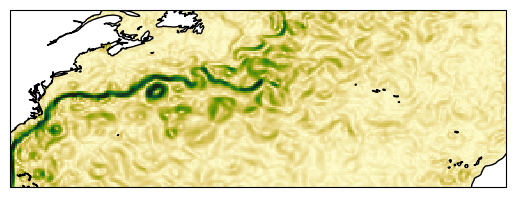

In [11]:
duacs_ds = read_zarr(root=f"{S3_ROOT}/duacs.zarr", s3=S3_FS)

plot_ssc(duacs_ds.sel(time=START_TIME))

#### MIOST

<GeoAxes: >

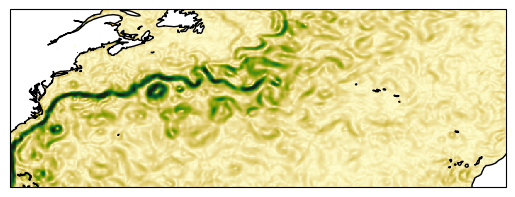

In [12]:
miost_ds = read_zarr(root=f"{S3_ROOT}/miost.zarr", s3=S3_FS)
miost_ds["longitude"] = (miost_ds["longitude"] + 180) % 360 - 180  # need to transform the longitudes

plot_ssc(miost_ds.sel(time=START_TIME))

#### VarDyn

<GeoAxes: >

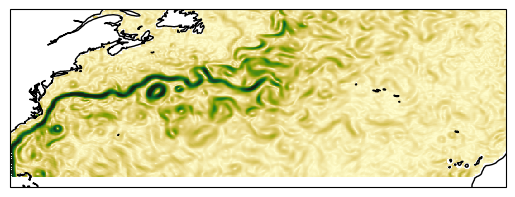

In [13]:
vardyn_ds = read_zarr(root=f"{S3_ROOT}/vardyn.zarr", s3=S3_FS)
vardyn_ds["longitude"] = (vardyn_ds["longitude"] + 180) % 360 - 180  # need to transform the longitudes

plot_ssc(vardyn_ds.sel(time=START_TIME))

#### 4dVarNet

<GeoAxes: >

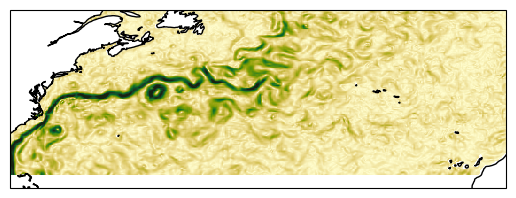

In [14]:
fdvarnet_ds = read_zarr(root=f"{S3_ROOT}/4dvarnet.zarr", s3=S3_FS)
fdvarnet_ds["longitude"] = (fdvarnet_ds["longitude"] + 180) % 360 - 180  # need to transform the longitudes

plot_ssc(fdvarnet_ds.sel(time=START_TIME))

### GDP Drifters

MIOST, VarDyn, 4dVarNet datasets from Aviso+ start at 2023-07-27: we will have to use the GDP6H dataset.

In [15]:
drifters_ds = read_zarr(root=f"{S3_ROOT}/gdp6h.zarr", s3=S3_FS)
drifter_ds = cd.ragged.subset(
    drifters_ds,
    {
        "WMO": lambda wmo: (wmo == WMO).compute(),
        "time": lambda time: (
            (time >= np.datetime64(START_TIME)) & 
            (time < np.datetime64(START_TIME) + np.timedelta64(N_DAYS, "D"))
        )
    },
    row_dim_name="traj"
)

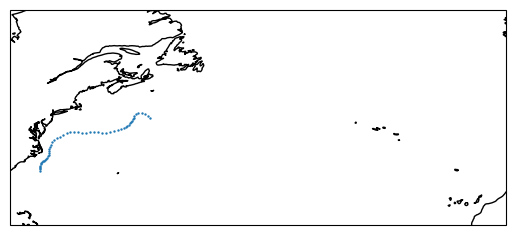

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.scatter(drifter_ds.lon, drifter_ds.lat, s=0.5)

ax.set_extent([-80, -10, 25, 50])
ax.coastlines()

## Trajectory ensemble simulations

We use OceanParcels with a Smagorinsky diffusion to generate ensembles starting at the same space/time location of our reference trajectory and then advected by the geostrophic currents derived from each SSH mapping product.

In [17]:
duacs_ssc_ds, reference_trajectory, duacs_traj_sim_ens = simulate_traj_ensemble(
    mapping_product="duacs",
    drifter_wmo=WMO,
    start_time=np.datetime64(START_TIME),
    traj_length=np.timedelta64(N_DAYS, "D"),
    ens_size=ENS_SIZE,
    s3_root=S3_ROOT,
    s3_fs=S3_FS
)

INFO: Output files are stored in traj_sim_duacs.zarr.
100%|██████████| 1209600.0/1209600.0 [00:03<00:00, 360219.98it/s]


In [18]:
miost_ssc_ds, reference_trajectory, miost_traj_sim_ens = simulate_traj_ensemble(
    mapping_product="miost",
    drifter_wmo=WMO,
    start_time=np.datetime64(START_TIME),
    traj_length=np.timedelta64(N_DAYS, "D"),
    ens_size=ENS_SIZE,
    s3_root=S3_ROOT,
    s3_fs=S3_FS
)

INFO: Output files are stored in traj_sim_miost.zarr.
100%|██████████| 1209600.0/1209600.0 [00:07<00:00, 171553.83it/s]


In [ ]:
vardyn_ssc_ds, reference_trajectory, vardyn_traj_sim_ens = simulate_traj_ensemble(
    mapping_product="vardyn",
    drifter_wmo=WMO,
    start_time=np.datetime64(START_TIME),
    traj_length=np.timedelta64(N_DAYS, "D"),
    ens_size=ENS_SIZE,
    s3_root=S3_ROOT,
    s3_fs=S3_FS
)

In [ ]:
fdvarnet_ssc_ds, reference_trajectory, fdvarnet_traj_sim_ens = simulate_traj_ensemble(
    mapping_product="4dvarnet",
    drifter_wmo=WMO,
    start_time=np.datetime64(START_TIME),
    traj_length=np.timedelta64(N_DAYS, "D"),
    ens_size=ENS_SIZE,
    s3_root=S3_ROOT,
    s3_fs=S3_FS
)

## Simulated ensembles visualisation

Plot the simulated ensembles (in red) and the reference trajectory (in blue). In the background we plot the magnitude of the SSC at the start time of the simulation.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

_ = plot_simulation(reference_trajectory, duacs_traj_sim_ens, duacs_ssc_ds.sel(time=START_TIME), axes[0, 0], title="DUACS")
_ = plot_simulation(reference_trajectory, miost_traj_sim_ens, miost_ssc_ds.sel(time=START_TIME), axes[0, 1], title="MIOST")
_ = plot_simulation(reference_trajectory, vardyn_traj_sim_ens, vardyn_ssc_ds.sel(time=START_TIME), axes[1, 1], title="VarDyn")
_ = plot_simulation(reference_trajectory, fdvarnet_traj_sim_ens, fdvarnet_ssc_ds.sel(time=START_TIME), axes[1, 0], title="4dVarNet")

plt.tight_layout()
plt.show()

## Compute metrics

We compute here the different metrics.

In [ ]:
duacs_distance = duacs_traj_sim_ens.lengths() / 1e3
miost_distance = miost_traj_sim_ens.lengths() / 1e3
vardyn_distance = vardyn_traj_sim_ens.lengths() / 1e3
fdvarnet_distance = fdvarnet_traj_sim_ens.lengths() / 1e3

### Between pairs

In [ ]:
duacs_liu_index = duacs_traj_sim_ens.liu_index(reference_trajectory)
duacs_separation_distance = duacs_traj_sim_ens.separation_distance(reference_trajectory) / 1e3

miost_liu_index = miost_traj_sim_ens.liu_index(reference_trajectory)
miost_separation_distance = miost_traj_sim_ens.separation_distance(reference_trajectory) / 1e3

vardyn_liu_index = vardyn_traj_sim_ens.liu_index(reference_trajectory)
vardyn_separation_distance = vardyn_traj_sim_ens.separation_distance(reference_trajectory) / 1e3

fdvarnet_liu_index = fdvarnet_traj_sim_ens.liu_index(reference_trajectory)
fdvarnet_separation_distance = fdvarnet_traj_sim_ens.separation_distance(reference_trajectory) / 1e3

### Ensemble

In [ ]:
n_members = duacs_traj_sim_ens.size
norm_factor = (n_members * (n_members - 1))

duacs_crps = duacs_traj_sim_ens.crps(reference_trajectory) / 1e3
duacs_dispersion = duacs_traj_sim_ens.ensemble_dispersion(Trajectory.separation_distance) / 1e3 / norm_factor
miost_crps = miost_traj_sim_ens.crps(reference_trajectory) / 1e3
miost_dispersion = miost_traj_sim_ens.ensemble_dispersion(Trajectory.separation_distance) / 1e3 / norm_factor
vardyn_crps = vardyn_traj_sim_ens.crps(reference_trajectory) / 1e3
vardyn_dispersion = vardyn_traj_sim_ens.ensemble_dispersion(Trajectory.separation_distance) / 1e3 / norm_factor
fdvarnet_crps = fdvarnet_traj_sim_ens.crps(reference_trajectory) / 1e3
fdvarnet_dispersion = fdvarnet_traj_sim_ens.ensemble_dispersion(Trajectory.separation_distance) / 1e3 / norm_factor

duacs_crps_liu_index = duacs_traj_sim_ens.crps(reference_trajectory, Trajectory.liu_index)
duacs_dispersion_liu_index = duacs_traj_sim_ens.ensemble_dispersion(Trajectory.liu_index) / norm_factor
miost_crps_liu_index = miost_traj_sim_ens.crps(reference_trajectory, Trajectory.liu_index)
miost_dispersion_liu_index = miost_traj_sim_ens.ensemble_dispersion(Trajectory.liu_index) / norm_factor
vardyn_crps_liu_index = vardyn_traj_sim_ens.crps(reference_trajectory, Trajectory.liu_index)
vardyn_dispersion_liu_index = vardyn_traj_sim_ens.ensemble_dispersion(Trajectory.liu_index) / norm_factor
fdvarnet_crps_liu_index = fdvarnet_traj_sim_ens.crps(reference_trajectory, Trajectory.liu_index)
fdvarnet_dispersion_liu_index = fdvarnet_traj_sim_ens.ensemble_dispersion(Trajectory.liu_index) / norm_factor

## Metrics visualisation

In [ ]:
days = seconds_to_days(reference_trajectory.times - reference_trajectory.times[0])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax = plot_metric(
    duacs_distance, days, 
    ax=axes[0, 0], title="DUACS"
)
ax.set_ylim(0, 1800)
ax.set_ylabel("Travel distance [km]")

ax = plot_metric(
    miost_distance, days, 
    ax=axes[0, 1], title="MIOST"
)
ax.set_ylim(0, 1800)

ax = plot_metric(
    vardyn_distance, days, 
    ax=axes[1, 1], title="VarDyn"
)
ax.set_ylim(0, 1800)
ax.set_xlabel("Days")
ax.legend(loc="upper left")

ax = plot_metric(
    fdvarnet_distance, days, 
    ax=axes[1, 0], title="4dVarNet"
)
ax.set_ylim(0, 1800)
ax.set_xlabel("Days")
ax.set_ylabel("Travel distance [km]")

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax = plot_metric(
    duacs_separation_distance, days, 
    {"CRPS": duacs_crps, "dispersion": duacs_dispersion},
    ax=axes[0, 0], title="DUACS"
)
ax.set_ylim(0, 1800)
ax.set_ylabel("Separation distance [km]")

ax = plot_metric(
    miost_separation_distance, days, 
    {"CRPS": miost_crps, "dispersion": miost_dispersion},
    ax=axes[0, 1], title="MIOST"
)
ax.set_ylim(0, 1800)

ax = plot_metric(
    vardyn_separation_distance, days, 
    {"CRPS": vardyn_crps, "dispersion": vardyn_dispersion},
    ax=axes[1, 1], title="VarDyn"
)
ax.set_ylim(0, 1800)
ax.set_xlabel("Days")
ax.legend(loc="upper left")

ax = plot_metric(
    fdvarnet_separation_distance, days, 
    {"CRPS": fdvarnet_crps, "dispersion": fdvarnet_dispersion},
    ax=axes[1, 0], title="4dVarNet"
)
ax.set_ylim(0, 1800)
ax.set_xlabel("Days")
ax.set_ylabel("Separation distance [km]")

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax = plot_metric(
    duacs_liu_index, days, 
    {"CRPS": duacs_crps_liu_index},
    ax=axes[0, 0], title="DUACS"
)
ax.set_ylim(0, 1)
ax.set_ylabel("Liu index")

ax = plot_metric(
    miost_liu_index, days, 
    {"CRPS": miost_crps_liu_index},
    ax=axes[0, 1], title="MIOST"
)
ax.set_ylim(0, 1)

ax = plot_metric(
    vardyn_liu_index, days, 
    {"CRPS": vardyn_crps_liu_index},
    ax=axes[1, 1], title="VarDyn"
)
ax.set_ylim(0, 1)
ax.set_xlabel("Days")
ax.legend(loc="upper left")

ax = plot_metric(
    fdvarnet_liu_index, days,
    {"CRPS": fdvarnet_crps_liu_index}, 
    ax=axes[1, 0], title="4dVarNet"
)
ax.set_ylim(0, 1)
ax.set_xlabel("Days")
ax.set_ylabel("Liu index")

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(days, duacs_crps, label="DUACS")
ax1.plot(days, miost_crps, label="MIOST")
ax1.plot(days, vardyn_crps, label="VarDyn")
ax1.plot(days, fdvarnet_crps, label="4dVarNet")
ax1.set_ylim(0, 1800)
ax1.set_xlabel("Days")
ax1.set_ylabel("Separation distance CRPS [km]")

ax2.plot(days, duacs_crps_liu_index, label="DUACS")
ax2.plot(days, miost_crps_liu_index, label="MIOST")
ax2.plot(days, vardyn_crps_liu_index, label="VarDyn")
ax2.plot(days, fdvarnet_crps_liu_index, label="4dVarNet")
ax2.set_ylim(0, 1)
ax2.set_xlabel("Days")
ax2.set_ylabel("Liu index CRPS")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.hist(duacs_distance[:, -1], bins=10, alpha=0.5, label="DUACS")
ax.hist(miost_distance[:, -1], bins=10, alpha=0.5, label="MIOST")
ax.hist(vardyn_distance[:, -1], bins=10, alpha=0.5, label="VarDyn")
ax.hist(fdvarnet_distance[:, -1], bins=10, alpha=0.5, label="4dVarNet")

ax.set_ylabel("Frequency")
ax.set_xlabel("Travel distance [km]")
ax.legend(loc="upper right")

fig.suptitle("Histogram (last position)")

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(duacs_liu_index[:, -1], bins=10, alpha=0.5, label="DUACS")
ax1.hist(miost_liu_index[:, -1], bins=10, alpha=0.5, label="MIOST")
ax1.hist(vardyn_liu_index[:, -1], bins=10, alpha=0.5, label="VarDyn")
ax1.hist(fdvarnet_liu_index[:, -1], bins=10, alpha=0.5, label="4dVarNet")

ax1.set_xlabel("Liu index")
ax1.set_ylabel("Frequency")
ax1.legend(loc="upper right")

ax2.hist(duacs_separation_distance[:, -1], bins=10, alpha=0.5, label="DUACS")
ax2.hist(miost_separation_distance[:, -1], bins=10, alpha=0.5, label="MIOST")
ax2.hist(vardyn_separation_distance[:, -1], bins=10, alpha=0.5, label="VarDyn")
ax2.hist(fdvarnet_separation_distance[:, -1], bins=10, alpha=0.5, label="4dVarNet")

ax2.set_xlabel("Separation distance [km]")

fig.suptitle("Histogram (last position)")

plt.show()